# **Data scraping of Spotify / Genius artists**

## Imports 

In [13]:
import os
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import tqdm as tqdm
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import time
from collections import deque
from openai import OpenAI
import ast

load_dotenv()


SPOTIFY_API_KEY = os.getenv("SPOTIFY_API_KEY_3")
SPOTIFY_CLIENT_ID = os.getenv("SPOTIFY_CLIENT_ID_3")
GENIUS_TOKEN = os.getenv("GENIUS_TOKEN")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

TOP_100_PLAYLIST_ID = "0sDahzOkMWOmLXfTMf2N4N"
TIKTOK_PLAYLIST_ID = "57EG9lWmdn7HHofXuQVsow"

auth_manager = SpotifyClientCredentials(client_id=SPOTIFY_CLIENT_ID, client_secret=SPOTIFY_API_KEY)
sp = spotipy.Spotify(auth_manager=auth_manager)
llm = OpenAI(api_key=OPENAI_API_KEY)

## Creating sets for top 100 artist and TikTok's songs 

In [14]:
results_top_100 = sp.playlist_items(TOP_100_PLAYLIST_ID)
print("Total number of tracks:", len(results_top_100["items"]))
artist_names = []
for item in results_top_100["items"]:
    track = item["track"]
    artist_names.append(track['artists'][0]['name'])

unique_artist_names_top_100 = set(artist_names)
print("Unique artists in top 100 playlist:", len(unique_artist_names_top_100))

results_tiktok = sp.playlist_items(TIKTOK_PLAYLIST_ID)
print("\nTotal number of tracks in TikTok playlist:", len(results_tiktok["items"]))
artist_names = []
for item in results_tiktok["items"]:
    track = item["track"]
    artist_names.append(track['artists'][0]['name'])
unique_artist_names_tiktok = set(artist_names)
print(f"Unique artists in TikTok playlist: {len(unique_artist_names_tiktok)}\n")

Total number of tracks: 98
Unique artists in top 100 playlist: 44

Total number of tracks in TikTok playlist: 100
Unique artists in TikTok playlist: 85



## Helper functions

In [15]:
def load_checkpoint(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    return None

def save_checkpoint(filename, graph, frontier, node_attributes, artist_ids, current_depth):
    with open(filename, 'wb') as f:
        pickle.dump({
            'graph': graph,
            'frontier': frontier,
            'node_attributes': node_attributes,
            'artist_ids': artist_ids,
            'current_depth': current_depth
        }, f)

In [16]:
class RateLimiter:
    def __init__(self, max_requests=50, window_seconds=30):
        self.max_requests = max_requests
        self.window_seconds = window_seconds
        self.requests = deque()
    
    def wait_if_needed(self):
        now = time.time()
        
        # remove requests older than the window
        while self.requests and self.requests[0] < now - self.window_seconds:
            self.requests.popleft()
        
        # wait until oldest request expires
        if len(self.requests) >= self.max_requests:
            sleep_time = self.window_seconds - (now - self.requests[0]) + 0.5
            if sleep_time > 0:
                print(f"Rate limit reached. Waiting {sleep_time:.1f}s...")
                time.sleep(sleep_time)
                now = time.time()
                while self.requests and self.requests[0] < now - self.window_seconds:
                    self.requests.popleft()
        
        self.requests.append(now)
    
    def get_current_rate(self):
        now = time.time()
        # remove old requests
        while self.requests and self.requests[0] < now - self.window_seconds:
            self.requests.popleft()
        return len(self.requests)

 ### Getting featured artists
We must have `include_groups = 'ablum,single'` to avoid getting artist's "appears on" albums - which are not really collaborations (featuring).


In [17]:
def get_featured_artists(artist_id, sp_client, rate_limiter, max_albums=20, 
                        include_groups='album,single', max_tracks_per_album=None):
    """
    Return aligned lists of featured artist names and ids, deduplicated by id.
    """
    pairs_by_id = {}
    
    rate_limiter.wait_if_needed()
    albums_page = sp_client.artist_albums(artist_id, include_groups=include_groups, limit=max_albums)
    album_items = albums_page.get("items", [])[:max_albums]
    album_ids = [a["id"] for a in album_items if a.get("id")]
    
    if not album_ids:
        return [], []
    
    rate_limiter.wait_if_needed()
    albums_resp = sp_client.albums(album_ids)
    
    for album in (albums_resp.get("albums") or []):
        tracks_block = (album.get("tracks") or {})
        tracks = tracks_block.get("items", [])
        
        if max_tracks_per_album is not None:
            tracks = tracks[:max_tracks_per_album]
        
        for tr in tracks:
            for a in tr.get("artists", []):
                aid = a.get("id")
                if aid and aid != artist_id:
                    pairs_by_id[aid] = a.get("name", aid)
    
    feature_artist_ids = list(pairs_by_id.keys())
    feature_artists = [pairs_by_id[_id] for _id in feature_artist_ids]
    return feature_artists, feature_artist_ids

### Lyrics extractor
This is a function built to extract lyrics from the "Genius" website. Inputs are the song title and artist names both as string, and the output is the lyrics as a string.


In [18]:
def get_lyrics(song_title, artist_name):
    base_url = "https://api.genius.com/search"
    headers = {"Authorization": f"Bearer {GENIUS_TOKEN}"}
    params = {"q": f"{song_title} {artist_name}"}
    response = requests.get(base_url, headers=headers, params=params).json()

    hits = response["response"]["hits"]
    if not hits:
        return None

    for hit in hits:
        result = hit["result"]
        if result["primary_artist"]["name"].lower() == artist_name.lower():
            song_url = result["url"]
            break
    else:
        song_url = hits[0]["result"]["url"]

    page = requests.get(song_url)
    soup = BeautifulSoup(page.text, "html.parser")

    lyrics_divs = soup.select("div[data-lyrics-container='true']")
    if lyrics_divs:
        lyrics = "\n".join(div.get_text(separator="\n") for div in lyrics_divs)
    else:
        candidates = soup.find_all("div", class_=re.compile("(Lyrics__Root|Lyrics-sc-|SongPage__Section)"))
        lyrics = "\n".join(c.get_text(separator="\n") for c in candidates) if candidates else ""

    match = re.search(r"\[verse\s*1\]", lyrics, flags=re.IGNORECASE)
    if match:
        lyrics = lyrics[match.start():]
    
    lyrics = re.sub(r"\[.*?\]", "", lyrics)
    lyrics = re.split(r"You might also like|Embed|See.*Lyrics$", lyrics)[0].strip()

    return lyrics if lyrics else None

## Feature scraper

Combines all the code above to create a dictionary representing the graph and a second containing the node's attributes.

In [19]:
def feature_scraper():
    """Under construction"""
    # size of frontier per iteration 0: 44 -> 1: 781/2 -> 2: 12146

In [20]:
artist_ids = {}
for item in results_top_100["items"]:
    track = item["track"]
    if track and track.get("artists"):
        a = track["artists"][0]
        if a.get("name") and a.get("id"):
            artist_ids[a["name"]] = a["id"]

for item in results_tiktok["items"]:
    track = item["track"]
    if track and track.get("artists"):
        a = track["artists"][0]
        if a.get("name") and a.get("id"):
            artist_ids.setdefault(a["name"], a["id"])


graph = {artist_name: [] for artist_name in unique_artist_names_top_100}
node_attributes = {artist_name: {} for artist_name in unique_artist_names_top_100}

api_keys = [
    (os.getenv("SPOTIFY_CLIENT_ID_1"), os.getenv("SPOTIFY_API_KEY_1")),
    (os.getenv("SPOTIFY_CLIENT_ID_2"), os.getenv("SPOTIFY_API_KEY_2")),
    (os.getenv("SPOTIFY_CLIENT_ID_3"), os.getenv("SPOTIFY_API_KEY_3")),
    (os.getenv("SPOTIFY_CLIENT_ID_4"), os.getenv("SPOTIFY_API_KEY_4")),
    (os.getenv("SPOTIFY_CLIENT_ID_5"), os.getenv("SPOTIFY_API_KEY_5"))
]

## Clean data post scraping

In [21]:
def impute_missing_genres(node_attributes):
    def impute_genres_llm(artist_name, spotify_genres):
        not_successful_artist = []
        prompt = (
            f"Identify 1, 2 or 3 plausible music genres (short labels) for the recording artist '{artist_name}'. "
            f"Use widely known information about releases and collaborations. "
            f"If the artist is represented by a genre that is present in this list: {spotify_genres}, use the same genre labels. "
            f"Return ONLY a Python list like ['genre1','genre2']. If uncertain return ['NoGenre']."
        )
        try:
            resp = llm.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {"role": "system", "content": "Output only a Python list of 1, 2 or 3 genre labels."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.25,
                max_tokens=40
            )
            raw = resp.choices[0].message.content.strip()
            genres = ast.literal_eval(raw)
            if not isinstance(genres, list):
                raise ValueError("Response not a list")
            cleaned = []
            for g in genres:
                g_norm = str(g).strip().lower()
                if g_norm:
                    cleaned.append(g_norm)
                if len(cleaned) == 3:
                    break
            if not cleaned:
                not_successful_artist.append(artist_name)
                cleaned = ["NoGenre"]
            return cleaned
        except Exception as e:
            print(f"LLM failed for {artist_name}: {e}")
            not_successful_artist.append(artist_name)
            return ["NoGenre"]
    
    # remove empty names from empty_genre_artists
    missing_artists = [
        artist for artist, attrs in node_attributes.items()
        if not attrs.get("genres") and artist.strip()
    ]

    spotify_genres = list(set([genre for attrs in node_attributes.values() for genre in attrs.get("genres", [])]))
    
    for artist in missing_artists:
        if artist in artist_ids:
            genres = sp.artist(artist_ids[artist])
        else:
            # get artist id via search
            search_results = sp.search(q=f"artist:{artist}", type="artist", limit=1)
            id = search_results.get("artists", {}).get("items", [])[0].get("id")
            genres = sp.artist(id)

        if genres.get('genres'):
            node_attributes[artist]['genres'] = genres.get('genres', [])
        else:
            node_attributes[artist]['genres'] = impute_genres_llm(artist, spotify_genres)  
    return node_attributes  

In [22]:
def clean_data(filename): 
    data = load_checkpoint(filename)
    graph = data['graph']
    node_attributes = data['node_attributes']

    # keep only edges with nodes that are in the graph's nodes
    graph_cleaned = {artist: [neighbor for neighbor in neighbors if neighbor in graph.keys()] for artist, neighbors in graph.items()}

    # keep only the top 5 songs per artist and rename to top_5_tracks
    for artist in node_attributes:
        node_attributes[artist]['top_5_tracks'] = node_attributes[artist].pop('top_10_tracks')[:5]

    # impute missing genres
    node_attributes = impute_missing_genres(node_attributes)

    return graph_cleaned, node_attributes

In [34]:
# DO NOT RUN THIS (unless you need to re-clean the data. Load cleaned data below)
# graph_cleaned, node_attributes = clean_data('data_final_lyrics_depth_2.pkl') 
# remove empty names
# node_attributes = {artist: attrs for artist, attrs in node_attributes.items() if artist.strip()}
# if "" in graph_cleaned.keys():
#     graph_cleaned.pop("")
# save_checkpoint('data_final_cleaned_depth_2.pkl', graph_cleaned, None, node_attributes, None, None)
data_cleaned = load_checkpoint('data_final_cleaned_depth_2.pkl')
graph_cleaned = data_cleaned['graph']
node_attributes = data_cleaned['node_attributes']

In [ ]:
############ TEST ###########

# find all artists with empty genres
empty_genre_artists = [artist for artist, attrs in node_attributes.items() if not attrs.get("genres") or attrs.get("genres") == ["NoGenre"]]
print(f"Artists with empty genres {len(empty_genre_artists)}, list is: {empty_genre_artists}\n")

# find all artists with no songs with lyrics
no_lyrics_artists = [artist for artist, attrs in node_attributes.items() if all(track.get("lyrics") is None for track in attrs.get("top_5_tracks", []))]
print(f"Artists with no songs with lyrics {len(no_lyrics_artists)}, list is: {no_lyrics_artists}\n")

# find all artists and each song without lyrics
songs_without_lyrics = {}
for artist, attrs in node_attributes.items():
    missing_lyrics_tracks = [track['name'] for track in attrs.get("top_5_tracks", []) if track.get("lyrics") is None]
    if missing_lyrics_tracks:
        songs_without_lyrics[artist] = missing_lyrics_tracks
print("Artists and their songs without lyrics:")
for artist, tracks in songs_without_lyrics.items():
    print(f"{artist}: {tracks}")

## Manually check if all lyrics are good

Artists with empty genres 0, list is: []

Artists with no songs with lyrics 24, list is: ['Kim Hill', 'Telvis Lawler Jr', 'BRYANN', 'Nicole Hurst', 'Childofnines', 'Danny Pino', 'Yfmroady', 'Big36oz', 'Ryan Adams', '2PRETTY', 'Raedio', 'Boniface', 'Bless', 'Style P', 'Julianne Moore', 'Drench', 'F1 The Album', 'Ab-Liva', 'Hadiya Eshe’', '4PF DT', 'Ashtro Bot', '$andeep', 'Nik Dodani', 'Kaitlyn Dever']

Artists and their songs without lyrics:
LAWUYI: ['Bernadine’s interlude']
Marcelo Zarvos: ['Helicopter Arrival', 'My New VP']
Don Toliver: ['Lose My Mind (feat. Doja Cat) [From F1® The Movie]']
ROSÉ: ['Messy (From F1® The Movie)']
Tate McRae: ['Just Keep Watching (From F1® The Movie)']
EastSide K-Boy: ["Ain't No Fun (feat. Dj Primetime & Kalan.FrFr)"]
Large Professor: ['I Juswanna Chill']
Mark Ronson: ['Valerie (feat. Amy Winehouse) - Version Revisited']
Diplo: ['Wish - Audiomack Trap Symphony Version']
Chefin: ['ADORO ESSA VIDA $$$']
El Alfa: ['Kriminal - Prod. by Roberto Ferrante']
Obi

# Plotting

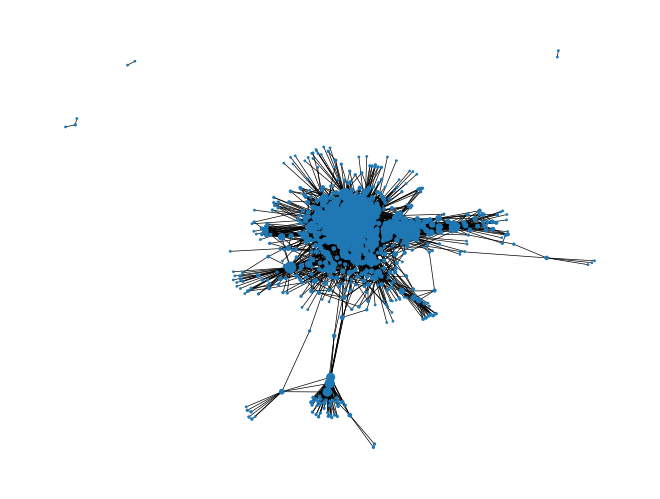

In [37]:
G = nx.Graph(graph_cleaned)
# add the node attributes from your dictionary
nx.set_node_attributes(G, node_attributes)
G_degrees = [G.degree(node) for node in G.nodes()]  
nx.draw(G, with_labels=False, width=0.5, node_size=[d*1 for d in G_degrees])
plt.show()

In [38]:
top_100_neighbors = []
max_neighbors = 0
for artist_name in G.nodes():
    num_neighbors = len(list(G.neighbors(artist_name)))
    top_100_neighbors.append(num_neighbors)
    if num_neighbors > max_neighbors:
        max_neighbors = num_neighbors
        most_connected_artist = artist_name

most_connected_artist, max_neighbors

('Lil Wayne', 133)

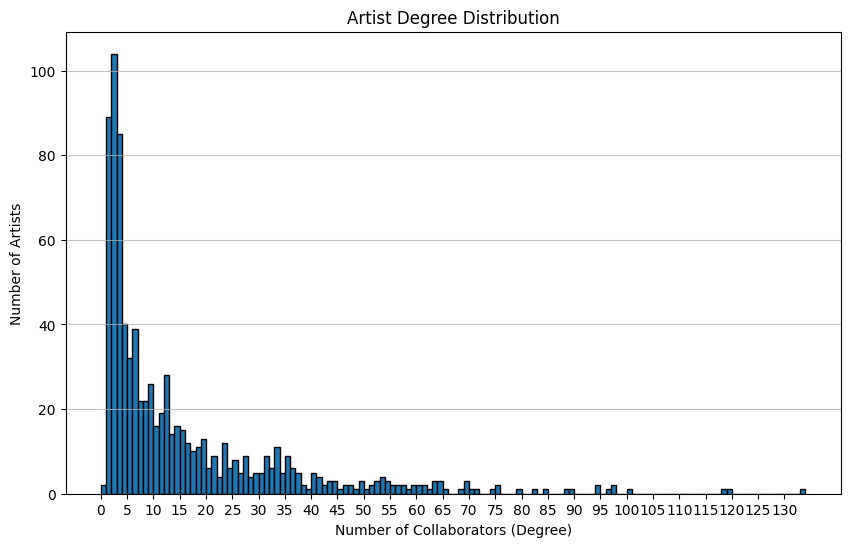

In [39]:
max_degree = max(top_100_neighbors)
bins = range(0, max_degree + 2) # Bins from 0 to max_degree+1

plt.figure(figsize=(10, 6))
plt.hist(top_100_neighbors, bins=bins, edgecolor='black')
plt.title('Artist Degree Distribution')
plt.xlabel('Number of Collaborators (Degree)')
plt.ylabel('Number of Artists')
plt.xticks(range(0, max_degree + 1, 5))
plt.grid(axis='y', alpha=0.75)
plt.show()